## Data Exploration

**1. Find our experiment records**

In [1]:
!rm data2/.DS_Store
from os import listdir
from os.path import isfile, join
data_raw = [f for f in listdir("data2") if isfile(join("data2", f))]
print(len(data_raw), "files:", str(data_raw))

7 files: ['46.8.csv', '21.8.csv', '18.3.csv', '53.8.csv', '58.6.csv', '19.7.csv', '39.1.csv']


**2. Save into a dictionary**

In [2]:
import csv
import numpy as np
data = {}
for experiment in data_raw:
    t, temp = [], []
    with open("data2/"+experiment) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            t.append(int(row[0])/1e3)
            temp.append(float(row[1]))
        data[experiment[:-4]] = (np.array(t), np.array(temp))

**3. Plot**

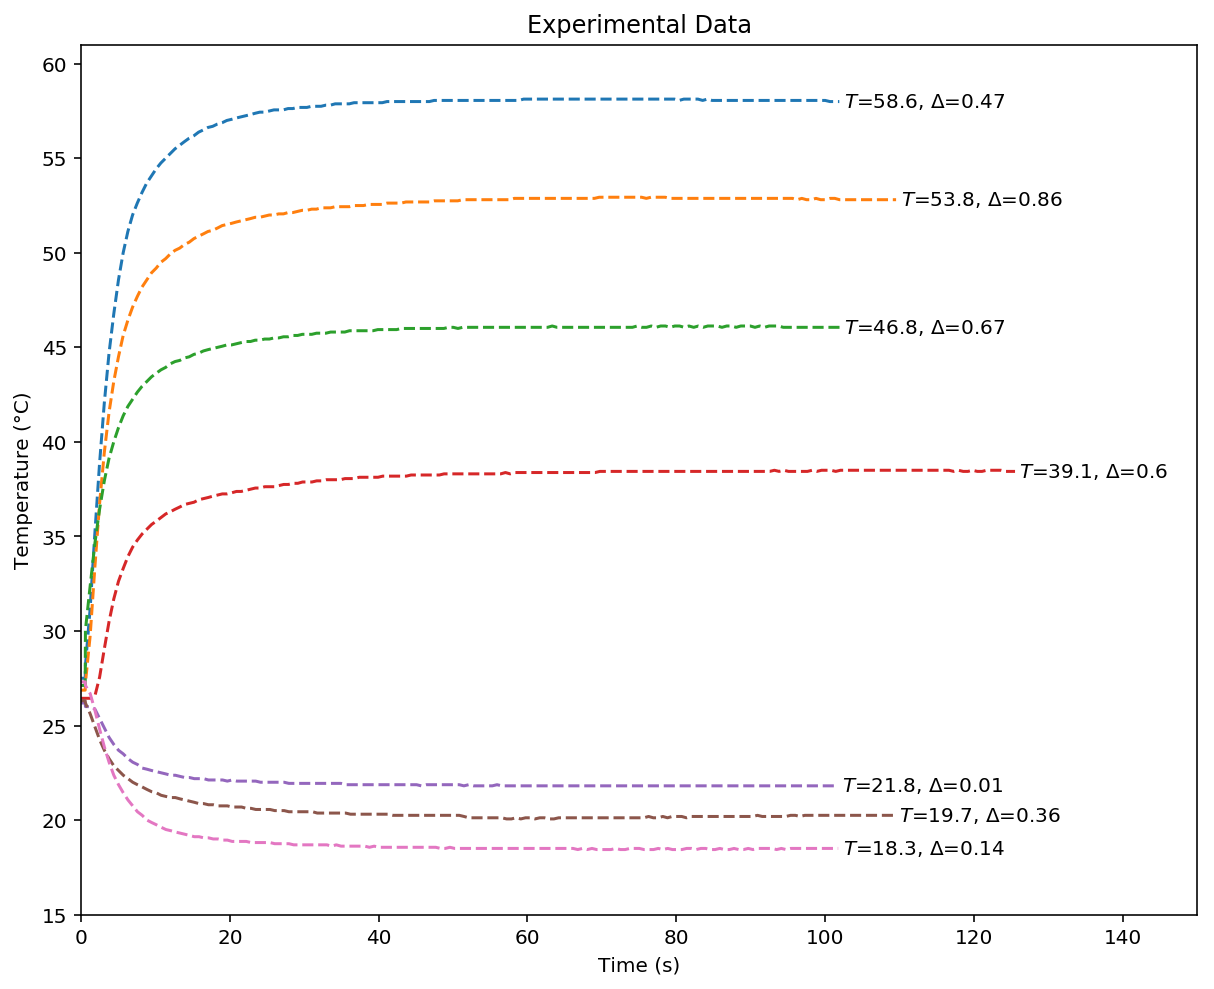

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.figure(1, figsize=(10, 8))
plt.title("Experimental Data")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.xticks(np.arange(0, 160, step=20))
plt.xlim(0,150)
plt.ylim(15,61)
plt.yticks(np.arange(15, 61, step=5))

ordered_experiments = list(data.keys())
ordered_experiments.sort()
for experiment in ordered_experiments[::-1]:
    t, temp = data[experiment]
    plt.plot(t, temp, '--', label=r"$T_i$="+experiment)
    if float(experiment) < 28:
        label = round(temp.min() - float(experiment), 2)
    else:
        label = round(float(experiment) - temp.max(), 2)
    plt.text(t[-1]+0.6,temp[-1]-0.3, r"$T$="+experiment+r", $\Delta$="+str(label))
    #plt.axhline(y=float(experiment), linestyle='--')
#plt.legend()
plt.show()

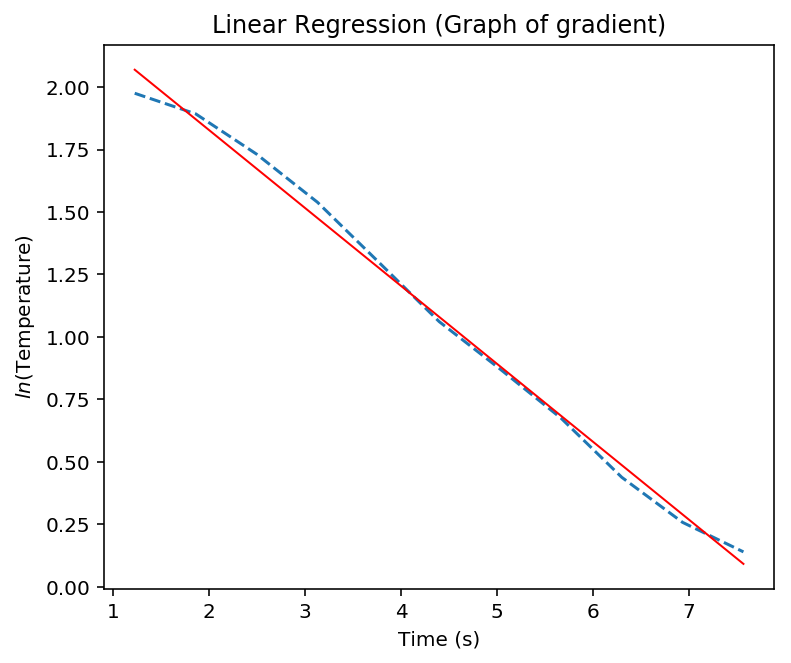

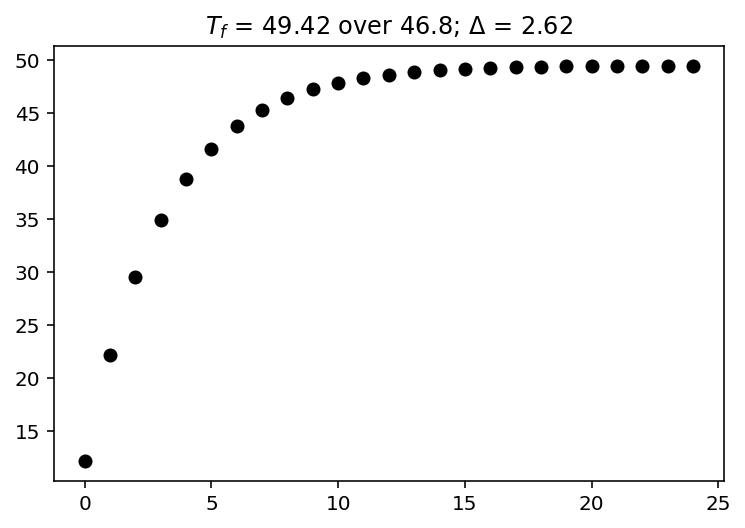

Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from math import e

for experiment in data.keys():
    t, temp = data[experiment]
    try:
        exp_diff = []
        t2 = []
        indexes = []
        for n, T in enumerate(temp[1:]):
            diff = (T - temp[n-1])/(t[n] - t[n-1])
            if diff>1 and diff<10:
                if len(exp_diff)==0:
                    exp_diff.append(diff)
                    t2.append(t[n])
                    indexes.append(n)
                else:
                    prev = exp_diff[-1]
                    exp_diff.append(0.7*diff+0.3*prev)
                    t2.append(t[n])
                    indexes.append(n)
        t2, exp_diff = np.array(t2).reshape(-1, 1), np.array(exp_diff).reshape(-1, 1)

        ln_exp_diff = np.log(exp_diff)
        regr = LinearRegression()
        regr.fit(t2, ln_exp_diff)
        exp_diff_pred = regr.predict(t2)

        n = indexes[int(len(indexes)/2)]
        k = regr.coef_[0][0]
        C = regr.predict([[0]])
        D = temp[n] - (1/k)*e**(k * t[n] + C)

        plt.figure(2, figsize=(6, 5))
        plt.title("Linear Regression (Graph of gradient)")
        plt.xlabel("Time (s)")
        plt.ylabel(r"$ln$(Temperature)")
        plt.plot(t2, ln_exp_diff, '--')
        plt.plot(t2, exp_diff_pred, color='red', linewidth=1)
        plt.show()
        
        temp_pred = []
        for t in range(0,25):
            temp = (1/k)*e**(k * t + C) + D
            temp_pred.append(temp)
    except Exception as error:
        print(error)
        exp_diff = []
        t2 = []
        indexes = []
        for n, T in enumerate(temp[1:]):
            diff = (T - temp[n-1])/(t[n] - t[n-1])
            if diff>1 and diff<10:
                print("what")
                if len(exp_diff)==0:
                    exp_diff.append(diff)
                    t2.append(t[n])
                    indexes.append(n)
                else:
                    prev = exp_diff[-1]
                    exp_diff.append(0.7*diff+0.3*prev)
                    t2.append(t[n])
                    indexes.append(n)
        t2, exp_diff = np.array(t2).reshape(-1, 1), np.array(exp_diff).reshape(-1, 1)

        ln_exp_diff = np.log(exp_diff)
        ln_exp_diff = np.log(-1*exp_diff)
        regr = LinearRegression()
        regr.fit(t2, ln_exp_diff)
        exp_diff_pred = regr.predict(t2)

        n = indexes[int(len(indexes)/2)]
        k = regr.coef_[0][0]
        C = regr.predict([[0]])
        D = temp[n] + (1/k)*e**(k * t[n] + C)

        plt.figure(2, figsize=(6, 5))
        plt.title("Linear Regression (Graph of gradient)")
        plt.xlabel("Time (s)")
        plt.ylabel(r"$ln$(Temperature)")
        plt.plot(t2, ln_exp_diff, '--')
        plt.plot(t2, exp_diff_pred, color='red', linewidth=1)
        plt.show()
        
        temp_pred = []
        for t in range(0,25):
            temp = (-1*(1/k)*e**(k * t + C) + D)
            temp_pred.append(temp)

    plt.scatter(range(0,25), temp_pred, color='black')
    plt.title(r"$T_f$ = " + str(round(temp_pred[-1][0][0],2)) + " over " + experiment + r"; Δ = " + str(round(abs(temp_pred[-1][0][0] - float(experiment)),2)))
    plt.show()